In this version, use Anthony's set up for P0YP0 P1YP1, and maybe implement concurrent VQE

In [4]:
%run SetUp.ipynb

from scipy.optimize import minimize

In [5]:
nQ = 6

## Define VQE form

In [6]:
# VQE
# "state" is the state PYP acts on. Implementing this way to not have to generate an entire matrix and save running time. 
# odd layer theta0*POYPO theta1*P1YP1 then even layer

def PYP(angle1,angle2, nq,state):
    n_sets = int(nq/2)
    for mm in range(n_sets):
        bb,cc,dd = (2*mm+1)%nq,(2*mm+2)%nq,(2*mm+3)%nq
        state = sp.sparse.linalg.expm_multiply(-1j * angle1 * pad_op(bb,nq,proj0) @ pad_op(cc,nq,y) @ pad_op(dd,nq,proj0),state) #-1j * 
        state = sp.sparse.linalg.expm_multiply(-1j * angle2 * pad_op(bb,nq,proj1) @ pad_op(cc,nq,y) @ pad_op(dd,nq,proj1),state)
    for m in range(n_sets):
        aa,bb,cc = (2*m)%nq,(2*m+1)%nq,(2*m+2)%nq
        state =  sp.sparse.linalg.expm_multiply(-1j * angle1 * pad_op(aa,nq,proj0) @ pad_op(bb,nq,y) @ pad_op(cc,nq,proj0),state)
        state =  sp.sparse.linalg.expm_multiply(-1j * angle2 * pad_op(aa,nq,proj1) @ pad_op(bb,nq,y) @ pad_op(cc,nq,proj1),state)
    return state


In [7]:

# Generate Fake Vacuum
# version that generates [[1,0,...]] and has dimension issues:  
#  fake_vac = ft.reduce(sp.sparse.kron, [[1,0]]* nq)

#fake_vac = sp.sparse.csr_array(np.ndarray.flatten(ft.reduce(sp.sparse.kron, [[1,0]]* nq).toarray()))

def fake_vac(nq):
    return sp.sparse.csr_array(ft.reduce(sp.sparse.kron, [[1.,0.]]* nq).toarray()).transpose()

## Set up function to minimize and initial points

In [8]:
# Generate a state from 2 angles
# Calculate full Hamiltonian expectation value for this state 
# Want to minimize this expectation value

num_params = 2

Hf = sp.sparse.csr_matrix(np.real(Hfull(nQ,m,g).to_matrix()))
fake_vac_nQ = fake_vac(nQ) # predefine to save runtime

def H_exp(angles):
    
    angle1, angle2 = angles[0], angles[1]    
    state = PYP(angle1,angle2,nQ,fake_vac_nQ) 
    
    val = state.conj().T @ Hf @ state
    
    return np.real(val.toarray()[0][0])

In [69]:
# Test to see if H_exp gets results as expected

test_state = sp.sparse.csr_array(mathematica_result_6_SU2).transpose()
test_val = test_state.conj().T @ Hf @ test_state
test_val.toarray()[0][0]

-0.7728417759483599

In [32]:

# activate 1 site. 

def activate1(init,loc,nq): # init is a function of nq, init(nq) is a state, loc is which link is activated
    #P0XP0 = math.pi/2* ft.reduce(sp.sparse.kron,[proj0,x,proj0])
    act_mat =ft.reduce(sp.sparse.kron, [sp.sparse.identity(2**(loc)),x,sp.sparse.identity(2**(nq-loc-1))]) 
    return act_mat @ init(nq)

In [ ]:
### Define alternate cost function to maximize for Concurrent VQE

L = 2 # place holder for number of p values. not sure what L means
# vac_full and meson_p_full are the eigenstates of the full Hamiltonian. Need to be defined. 

def cost_func(angles):
    angle1, angle2 = angles[0], angles[1]    
    
    vac_state = PYP(angle1,angle2,nQ,fake_vac_nQ) 
    
    meson_overlap = 0
    for index in range(L): # not including negative side for now. Is it symmetric? Can we do for p !=0 add 2*overlap to the total?
        p = (math.pi/L)*index
        # Sum over x to get |p>
        mesons = sp.sparse.csr_array(ft.reduce(sp.sparse.kron, [[0.,0.]]* nQ).toarray()).transpose()
        for x in range(nQ):
            meson_state = activate1(fake_vac,x,nQ)
            mesons += math.exp(1j*p*x) * meson_state
        meson_p = PYP(angle1,angle2,nQ,mesons/math.sqrt(2*L)) 
        meson_overlap += overlap(meson_p_full,meson_p)**2
    
    return (overlap(vac_full,vac_state)**2 + meson_overlap)/(2*L+1)

In [70]:
initial_point = np.random.rand(num_params)
H_exp(initial_point)

7.905870850754461

In [71]:
initial_point

array([0.73767256, 0.84244342])

In [72]:
H_exp([0, 0, 0])

0.0

## Run VQE

#### nelder-mead

In [73]:
res = minimize(H_exp, initial_point, method='nelder-mead',
               options={'xatol': 1e-8, 'disp': True})

Optimization terminated successfully.
         Current function value: -0.772596
         Iterations: 92
         Function evaluations: 179


In [74]:
print(res.x)

[-0.17752535 -0.04847129]


#### powell

In [75]:
res2 = minimize(H_exp, initial_point, method='powell',
               options={'disp': True})

Optimization terminated successfully.
         Current function value: -0.772596
         Iterations: 2
         Function evaluations: 49


In [76]:
print(res2.x)

[-0.17752534 -0.04848181]


#### BFGS

In [77]:
res3 = minimize(H_exp,initial_point, method='BFGS', tol = 1e-8,
               options={'disp': True})

# tol = 1e-8,
# xatol = 1e-8,

         Current function value: -0.772596
         Iterations: 13
         Function evaluations: 66
         Gradient evaluations: 22


/Users/zhiyaoli/anaconda3/envs/iqus/lib/python3.11/site-packages/scipy/optimize/_minimize.py:705: OptimizeWarning: Desired error not necessarily achieved due to precision loss.
  res = _minimize_bfgs(fun, x0, args, jac, callback, **options)


In [78]:
print(res3.x)

[-0.17752536 -0.04847119]


## Test

Agrees nicely with 6 qubits numerical results. Does not work great for 8 qubits but good for 12 qubits. Assuming 12 qubits is also divisable by 6,so the vqe_form are set up the same as 12, vs for 8 qubits there are some weird boundary stuff. 3 layers behave better than 1 layer for 12 qubits. 

#### Against mathematica result for 6 qubits

In [50]:
scipy_angles = [-0.17752535, -0.04847123]
scipy_results = np.reshape(PYP(-0.17752535, -0.04847123,nQ,fake_vac_nQ).toarray(),-1)

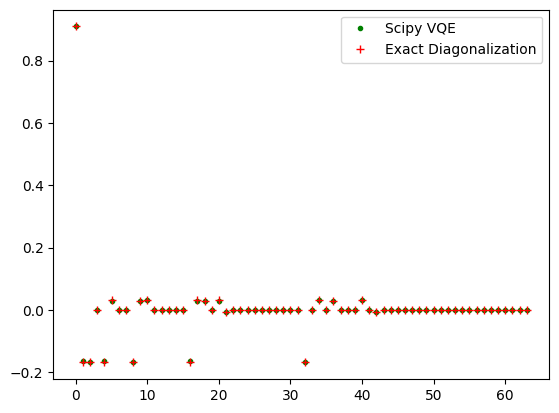

In [51]:
plt.plot(list(range(2**nQ)), scipy_results,'g.',label = 'Scipy VQE')
plt.plot(list(range(2**nQ)), mathematica_result_6_SU2,'r+',label = 'Exact Diagonalization')
plt.legend()

In [52]:
overlap(scipy_results,mathematica_result_6_SU2)

0.9999722122919408

#### Angle aquired from 6 qubits on 8 qubits

In [31]:
ang = [ 0.99561633, -0.26081946, -0.06735264]
nQ_8 = 8

vacuum_8 = np.reshape(apply_vqe_form(ang,nQ_8,fake_vac(nQ_8)).toarray(),-1)

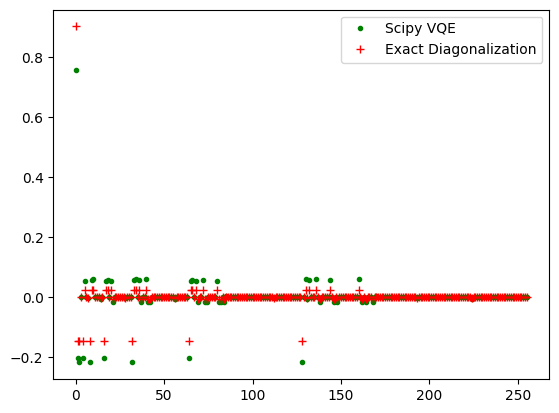

In [32]:
overlap(vacuum_8,mathematica_result_8_SU2)

In [173]:
Hf_8 = sp.sparse.csr_matrix(np.real(Hfull(nQ_8,m,g).to_matrix()))
vacuum_8 = apply_vqe_form(ang,nQ_8,fake_vac(nQ_8))

In [174]:
(vacuum_8.getH() @ Hf_8 @ vacuum_8).toarray()

/var/folders/px/x0b827mx07s9_8yq2xxdt9qr0000gr/T/ipykernel_5256/1847113859.py:1: DeprecationWarning: `getH` is deprecated and will be removed in v1.13.0; use `X.conj().T` instead.
  (vacuum_8.getH() @ Hf_8 @ vacuum_8).toarray()


array([[-0.92105169+0.j]])

#### Angle aquired from 6 qubits on 12 qubits (1 parameter)

In [54]:
ang = [-0.3188006]
nQQ = 12

In [55]:
Hf_12 = sp.sparse.csr_matrix(np.real(Hfull(nQQ,m,g).to_matrix()))
vacuum_12 = vqe_form(ang,nQQ).dot(fake_vac(nQQ))

/Users/zhiyaoli/anaconda3/envs/iqus/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/Users/zhiyaoli/anaconda3/envs/iqus/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/Users/zhiyaoli/anaconda3/envs/iqus/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


In [56]:
(vacuum_12.getH() @ Hf_12 @ vacuum_12).toarray()

array([[-1.38126538+0.j]])

In [57]:
vacuum_12

<4096x1 sparse matrix of type '<class 'numpy.complex128'>'
	with 466 stored elements in Compressed Sparse Row format>

/Users/zhiyaoli/anaconda3/envs/iqus/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/zhiyaoli/anaconda3/envs/iqus/lib/python3.11/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


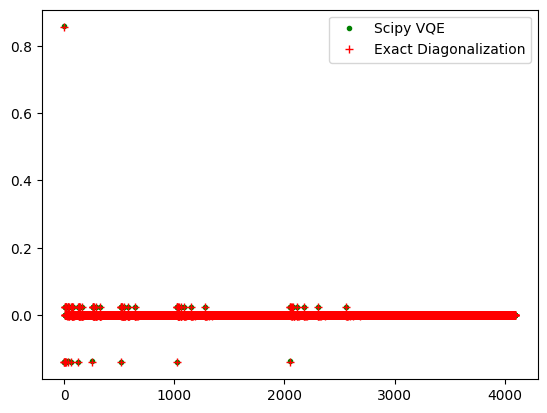

In [59]:
plt.plot(list(range(2**nQQ)), vacuum_12.toarray(),'g.',label = 'Scipy VQE')
plt.plot(list(range(2**nQQ)), np.array(mathematica_result_12_SU2),'r+',label = 'Exact Diagonalization')
plt.legend()

#### Angle aquired from 6 qubits on 12 qubits (3 parameters)

In [45]:
ang = [-0.08070716, -0.09582326, -0.14136288]
nQQ = 12

/Users/zhiyaoli/anaconda3/envs/iqus/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:412: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
/Users/zhiyaoli/anaconda3/envs/iqus/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:302: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '
/Users/zhiyaoli/anaconda3/envs/iqus/lib/python3.11/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:229: SparseEfficiencyWarning: spsolve requires A be CSC or CSR matrix format
  warn('spsolve requires A be CSC or CSR matrix format',


In [46]:
Hf_12 = sp.sparse.csr_matrix(np.real(Hfull(nQQ,m,g).to_matrix()))
vacuum_12 = vqe_form(ang,nQQ).dot(fake_vac(nQQ))

In [47]:
(vacuum_12.getH() @ Hf_12 @ vacuum_12).toarray()

array([[-1.38172513+0.j]])

In [51]:
vacuum_12

array([ 8.57812810e-01+0.j, -1.39827376e-01+0.j, -1.40379982e-01+0.j, ...,
       -1.38354625e-11+0.j, -1.10320339e-11+0.j,  1.58480933e-12+0.j])

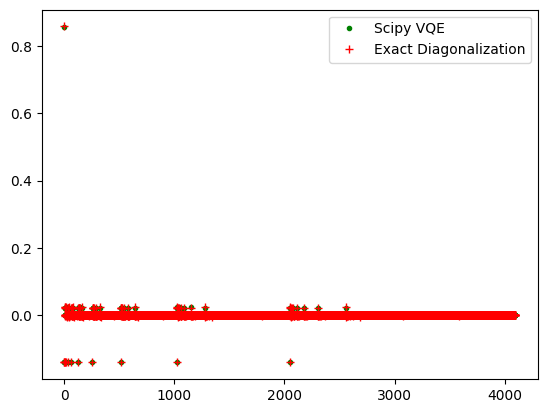

In [53]:
plt.plot(list(range(2**nQQ)), vacuum_12,'g.',label = 'Scipy VQE')
plt.plot(list(range(2**nQQ)), np.array(mathematica_result_12_SU2),'r+',label = 'Exact Diagonalization')
plt.legend()